# British Extremes #
This dataset is made up of tweets that link to news outlets that are seen as extremely partisan. The Daily Mail on the right, labelled 0, and The Guardian on the left, labelled 1. The set contains about 110,000 tweets.

Import libraries and load dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

DATASET = 'british_extremes'

tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()

In [0]:
with open('..\\dataset_creation\\datasets\\'+DATASET+'\\tweets.txt', encoding="utf8") as f:
    raw_tweets = f.readlines()

with open('..\\dataset_creation\\datasets\\'+DATASET+'\\labels.txt')as f:
    raw_labels = f.readlines()

target_dataset = list()
for label in raw_labels:
    if label == '1\n':
        target_dataset.append(1)
    else:
        target_dataset.append(0)

SPLIT = round(len(raw_tweets)*0.1)

Split test set and preprocess data

In [0]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 240)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    y_batch = tf.convert_to_tensor(y_batch, dtype=tf.int64)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [0]:
X_batch, y_batch = preprocess(raw_tweets, target_dataset)

In [0]:
X_test, X_train_full = X_batch[:SPLIT], X_batch[SPLIT:]
y_test, y_train_full = y_batch[:SPLIT], y_batch[SPLIT:]

Create vocabulary lookup table

In [0]:
vocabulary = Counter()
for tweet in X_train_full:
    vocabulary.update(list(tweet.numpy()))

In [0]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [0]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

Split validation set and encode words with look up table

In [0]:
def encode_words(dataset_input):
    return table.lookup(dataset_input)

In [0]:
X_valid, X_train = encode_words(X_train_full[:SPLIT]), encode_words(X_train_full[SPLIT:])
y_valid, y_train = y_train_full[:SPLIT], y_train_full[SPLIT:]

Define, compile and run model

In [0]:
embed_size = 8
model7 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, mask_zero=True),
    keras.layers.GRU(embed_size, dropout=0.5, activation="sigmoid", return_sequences=True),
    keras.layers.GRU(embed_size, dropout=0.5, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [0]:
model7.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           88000     
_________________________________________________________________
gru (GRU)                    (None, None, 8)           432       
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 88,873
Trainable params: 88,873
Non-trainable params: 0
_________________________________________________________________


In [15]:
history7 = model7.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Train on 88966 samples, validate on 11121 samples
Epoch 1/10
88966/88966 [==============================] - 210s 2ms/sample - loss: 0.6106 - accuracy: 0.6471 - val_loss: 0.4309 - val_accuracy: 0.8149
Epoch 2/10
88966/88966 [==============================] - 209s 2ms/sample - loss: 0.4534 - accuracy: 0.8026 - val_loss: 0.3907 - val_accuracy: 0.8351
Epoch 3/10
88966/88966 [==============================] - 211s 2ms/sample - loss: 0.4176 - accuracy: 0.8244 - val_loss: 0.3764 - val_accuracy: 0.8417
Epoch 4/10
88966/88966 [==============================] - 210s 2ms/sample - loss: 0.3953 - accuracy: 0.8358 - val_loss: 0.3703 - val_accuracy: 0.8435
Epoch 5/10
88966/88966 [==============================] - 209s 2ms/sample - loss: 0.3790 - accuracy: 0.8430 - val_loss: 0.3649 - val_accuracy: 0.8456
Epoch 6/10
88966/88966 [==============================] - 200s 2ms/sample - loss: 0.3659 - accuracy: 0.8477 - val_loss: 0.3605 - val_accuracy: 0.8485
Epoch 7/10
88966/88966 [==========================

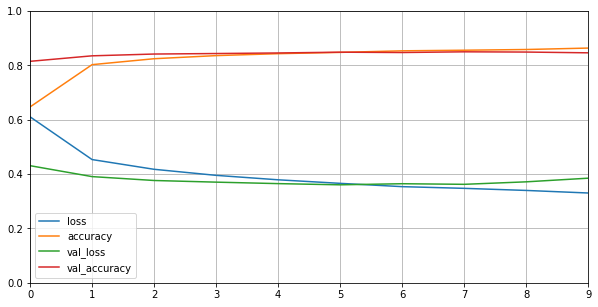

In [16]:
pd.DataFrame(history7.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, 9)
plt.show()

In [0]:
X_test_encoded = encode_words(X_test)

In [18]:
model7.evaluate(X_test_encoded, y_test)

11121/11121 [==============================] - 5s 458us/sample - loss: 0.3986 - accuracy: 0.8375


[0.39864552162521316, 0.83751464]

In [20]:
X_new = X_test_encoded[:10]
y_proba = model7.predict(X_new)
for i in range(len(y_proba)):
    print(str(i+1) + ".\nPrediction: " + str(y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

1.
Prediction: 0.66
Actual: 1

2.
Prediction: 0.34
Actual: 1

3.
Prediction: 0.55
Actual: 1

4.
Prediction: 0.08
Actual: 0

5.
Prediction: 0.06
Actual: 0

6.
Prediction: 0.61
Actual: 0

7.
Prediction: 0.06
Actual: 0

8.
Prediction: 0.09
Actual: 0

9.
Prediction: 0.48
Actual: 0

10.
Prediction: 0.64
Actual: 0



In [0]:
model7.save("saved_models\\" + DATASET + '.h5')

In [0]:
new_model = keras.models.load_model("saved_models\\" + DATASET + '.h5')

In [23]:
X_new = X_test_encoded[:10]
new_y_proba = new_model.predict(X_new)
for i in range(len(new_y_proba)):
    print(str(i+1) + ".\nPrediction: " + str(new_y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

1.
Prediction: 0.66
Actual: 1

2.
Prediction: 0.34
Actual: 1

3.
Prediction: 0.55
Actual: 1

4.
Prediction: 0.08
Actual: 0

5.
Prediction: 0.06
Actual: 0

6.
Prediction: 0.61
Actual: 0

7.
Prediction: 0.06
Actual: 0

8.
Prediction: 0.09
Actual: 0

9.
Prediction: 0.48
Actual: 0

10.
Prediction: 0.64
Actual: 0

